d:\ana\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


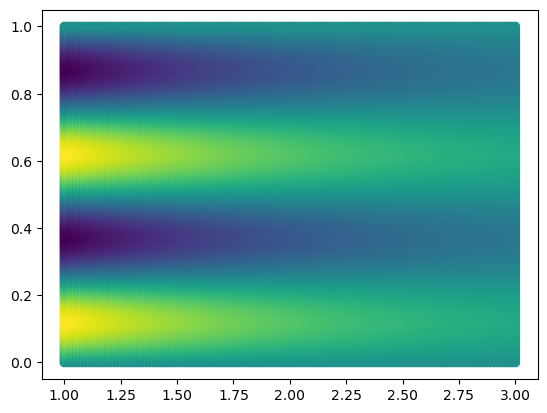

In [1]:
import sys
sys.path.append('../../')

import numpy as np
import torch
import matplotlib
np.random.seed(1)
torch.manual_seed(1)

from user_funn.field import D2Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad
from user_funn.geom import line_linspace

# define question
n = 4
a = 0.005
L = 1
tmax = 3

# get ana-solution
import heat_benchmark 
bm = heat_benchmark.HeatBenchMark(n,a,L,tmax)
X,y_true = bm.gen_testdata()
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c = y_true)


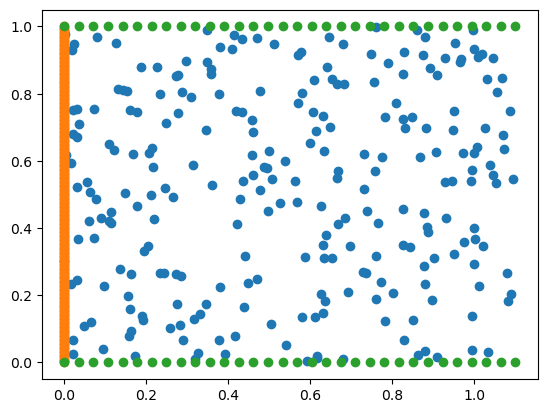

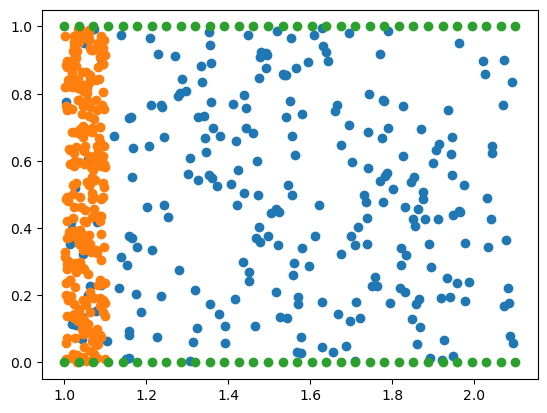

In [2]:
# 保证迭代参数与DEEPXDE一致
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()

# hyperparameter config
T_iter = 3
t_length = 3
t_length_per_iter = 1

t_span_start_list, overlap_start_list, t_span_end_list = [], [], []
pde_input_list,pde_output_list = [],[]
tc_input_list,tc_output_list = [],[]
bc_input_list,bc_output_list = [],[]

pde_epoch_size = 256
bc_epoch_size = 64
tc_epoch_size = 256

overlap_length = 0.1
for T_id in range(T_iter):
    t_span_start = T_id
    overlap_start = T_id+1
    t_span_end = (T_id+1) + overlap_length 
    t_span_start_list.append(t_span_start)
    overlap_start_list.append(overlap_start)
    t_span_end_list.append(t_span_end)
    
    pde_field = D2Field([t_span_start,t_span_end],[0,L])
    pde_input = pde_field.get_field_rand(pde_epoch_size)
    pde_output = np.zeros([pde_epoch_size,1])
    pde_input_list.append(pde_input)
    pde_output_list.append(pde_output)

    # define bc_input and bc_output 
    bc_input1 = line_linspace([t_span_start,0],[t_span_end,0],bc_epoch_size//2)
    bc_input2 = line_linspace([t_span_start,L],[t_span_end,L],bc_epoch_size//2)
    bc_input = np.vstack([bc_input1,bc_input2])
    bc_output = np.zeros([bc_epoch_size ,1])
    bc_input_list.append(bc_input)
    bc_output_list.append(bc_output)

    # define tc_input and tc_output
    if T_id == 0:
        tc_input = line_linspace([0,0],[0,L],tc_epoch_size)
    else:
        tc_field = D2Field([t_span_start, t_span_start+ overlap_length],[0,L])
        tc_input = tc_field.get_field_rand(tc_epoch_size)

    tc_input_list.append(tc_input)

tc_input_init = line_linspace([0,0],[0,L],tc_epoch_size)

tc_t = tc_input_init[:,0]
tc_x = tc_input_init[:,1]

tc_output_init = np.sin(n * np.pi * tc_x / L).reshape(tc_epoch_size,1)


# define loss
def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)
    # 数据提取
    t = x_in[:,[0]]
    x = x_in[:,[1]]
    u = U[:,[0]]
    # 计算一阶导
    dudi = grad(u, x_in)[0]
    dudt = dudi[:,[0]]
    dudx = dudi[:,[1]]
    # 计算二阶导
    du2dxi = grad(dudx, x_in)[0]
    du2dx2 = du2dxi[:,[1]]
    loss = dudt - a * du2dx2
    loss = loss_fn(loss, y_real)
    return loss

from user_funn.bc import data_loss_factory
tc_loss = data_loss_factory(loss_fn,[0])
bc_loss = data_loss_factory(loss_fn,[0])


import user_funn.plot
user_funn.plot.scatter_2d_cloud_point_kind(
    [pde_input_list[0], tc_input_list[0], bc_input_list[0]])
user_funn.plot.scatter_2d_cloud_point_kind(
    [pde_input_list[1], tc_input_list[1], bc_input_list[1]])



In [3]:

epoch_per_iter = 2000
x_all,y_pred_all,y_real_all = [],[],[]

T_iter = 3
for T_id in range(T_iter):
    t_span_start = T_id
    overlap_start = T_id+1
    t_span_end = (T_id+1) + overlap_length 
    seg_start = np.array([t_span_start,0]).reshape(1,2)
    
    ## define a tc
    if T_id == 0:
        tc_output = tc_output_init
    else:
        tc_output = last_solver.model_eval(tc_input_list[T_id] - seg_start \
            + np.array([1,0]).reshape(1,2))

    cloudpointlist = [
        [pde_input_list[T_id] - seg_start , pde_output_list[T_id]],
        [tc_input_list[T_id] - seg_start , tc_output],
        [bc_input_list[T_id] - seg_start , bc_output_list[T_id]]
    ]

    solver = CloudPointSolver(
        cloudpointlist,
        [pde_loss,tc_loss,bc_loss],
        model = [2, 50, 50, 50, 1],
        optimizer = "adam",
        batchsize = [pde_epoch_size, tc_epoch_size, bc_epoch_size])

    for epoch_local_id in range(epoch_per_iter):
        epoch_id = T_id * epoch_per_iter + epoch_local_id
        solver.train_step()
        if epoch_local_id % 100 == 0:
            solver.test_step(print_flag=True)

    last_solver = solver


    x_cpu,y_real = heat_benchmark.HeatBenchMark(n,a,L,
        tmin = t_span_start, tmax = overlap_start).gen_testdata()

    y_pred = solver.model_eval(x_cpu-seg_start)

    if T_id == 0:
        x_all = x_cpu
        y_pred_all = y_pred
        y_real_all = y_real
    else:
        x_all = np.vstack([x_all,x_cpu])
        y_pred_all = np.vstack([y_pred_all,y_pred])
        y_real_all = np.vstack([y_real_all, y_real])


loss is [0.00097139 0.48577327 0.00178163 0.4885263 ]
loss is [0.00547445 0.45346197 0.01136484 0.47030127]
loss is [0.00657646 0.45150587 0.01103277 0.46911508]
loss is [0.00665236 0.45040637 0.01120991 0.46826863]
loss is [0.01409143 0.4169497  0.01666271 0.44770384]
loss is [0.04641934 0.08192602 0.01041337 0.13875872]
loss is [0.01601511 0.01571575 0.00318985 0.03492071]
loss is [0.00329498 0.00269975 0.00082689 0.00682162]
loss is [0.00192389 0.0012594  0.00057374 0.00375703]
loss is [0.00145718 0.00079995 0.00046885 0.00272598]
loss is [0.00124291 0.00581478 0.00466896 0.01172666]
loss is [0.00119616 0.00050067 0.00034401 0.00204084]
loss is [0.00113049 0.00041969 0.00030883 0.00185902]
loss is [0.0010869  0.00051926 0.00038543 0.0019916 ]
loss is [0.00102796 0.00033794 0.00025215 0.00161806]
loss is [0.00098253 0.00030431 0.00023419 0.00152102]
loss is [0.00093734 0.00029818 0.00022113 0.00145665]
loss is [0.00090234 0.00026768 0.00020421 0.00137423]
loss is [0.00086353 0.000249

error 0.14785926238935534


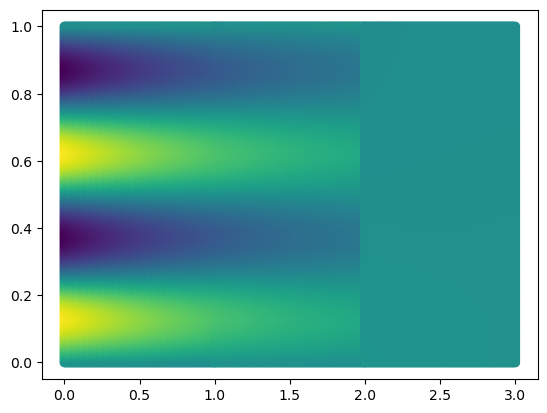

In [4]:

import matplotlib.pyplot as plt
plt.scatter(x_all[:,0],x_all[:,1],c = y_pred_all)
print('error',np.abs(y_real_all-y_pred_all).std()/y_real_all.std())